<a href="https://colab.research.google.com/github/praveenbhat73/self_driving_car/blob/main/signal_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal Training


In [4]:
! git clone https://bitbucket.org/self-driving/german-traffic-signs/src/master/

fatal: destination path 'master' already exists and is not an empty directory.


In [5]:
!ls master

signnames.csv  test.p  train.p	valid.p


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [7]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [8]:
%matplotlib inline
np.random.seed(0)
with open('master/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('master/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('master/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [9]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [10]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

In [11]:
data = pd.read_csv('master/signnames.csv')
  


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


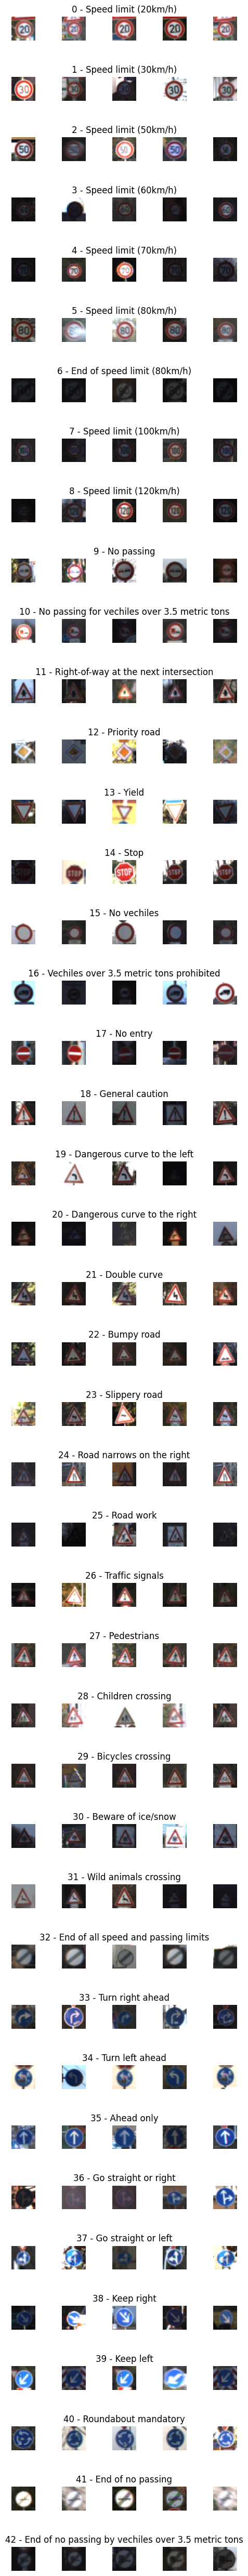

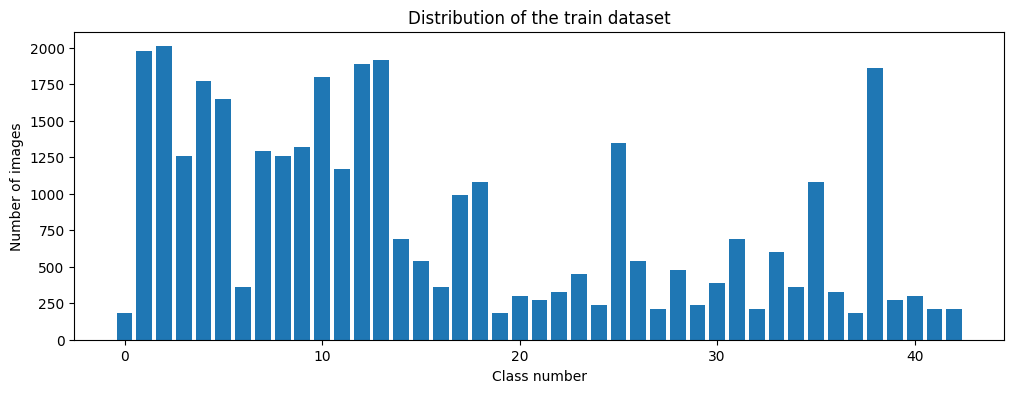

In [12]:
num_of_samples=[]
cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
      for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


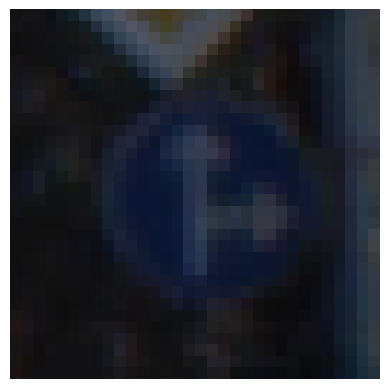

In [13]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)
(32, 32)
(34799, 32, 32)


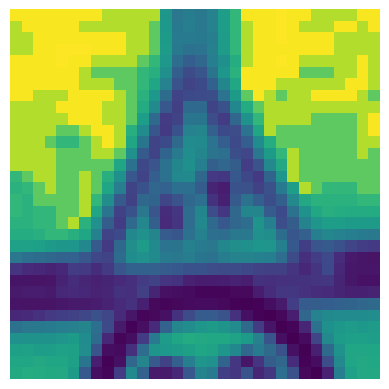

In [14]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
  
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)


In [15]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(15, 32, 32, 1)


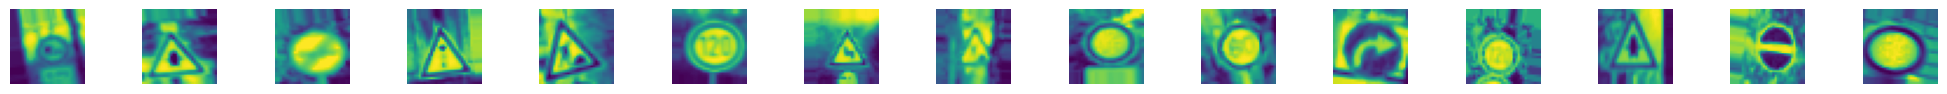

In [16]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [17]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)
# create model
 
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model
model = modified_model()
print(model.summary())
 
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=300,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-17-84a30cb810e0>:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),


None
Epoch 1/10
300/300 [==============================] - 190s 630ms/step - loss: 2.6156 - accuracy: 0.2804 - val_loss: 1.0154 - val_accuracy: 0.7195
Epoch 2/10
300/300 [==============================] - 188s 626ms/step - loss: 1.2404 - accuracy: 0.6261 - val_loss: 0.3905 - val_accuracy: 0.8855
Epoch 3/10
300/300 [==============================] - 192s 639ms/step - loss: 0.7655 - accuracy: 0.7657 - val_loss: 0.2384 - val_accuracy: 0.9279
Epoch 4/10
300/300 [==============================] - 194s 648ms/step - loss: 0.5449 - accuracy: 0.8306 - val_loss: 0.1665 - val_accuracy: 0.9508
Epoch 5/10
300/300 [==============================] - 186s 621ms/step - loss: 0.4046 - accuracy: 0.8743 - val_loss: 0.1345 - val_accuracy: 0.9571
Epoch 6/10
300/300 [==============================] - 194s 646ms/step - loss: 0.3622 - accuracy: 0.8859 - val_loss: 0.0971 - val_accuracy: 0.9712
Epoch 7/10
300/300 [==============================] - 195s 648ms/step - loss: 0.3038 - accuracy: 0.9031 - val_loss: 0.0

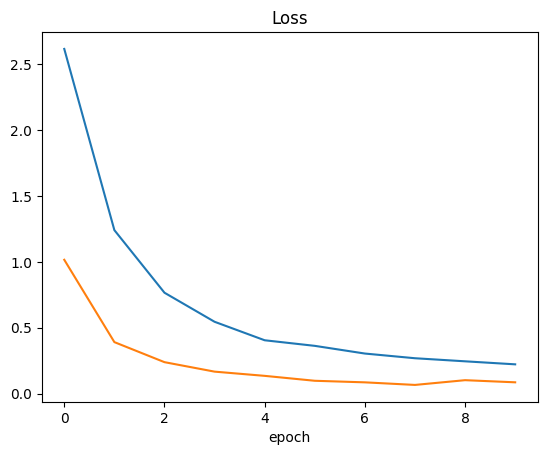

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
 
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.legend(['training','test'])
# plt.title('Accuracy')
# plt.xlabel('epoch')
 
# TODO: Evaluate model on test data
# score = model.evaluate(X_test, y_test, verbose=0)

Text(0.5, 0, 'epoch')

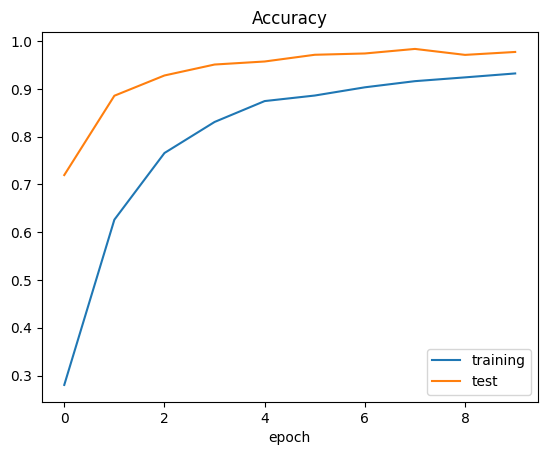

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [35]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#predict internet number
# import requests
# from PIL import Image
# url = 'https://www.jhpolice.gov.in/sites/default/files/page/sign-language/jhpolice_sl_mrs1.jpg'
# r = requests.get(url, stream=True)
# img = Image.open(r.raw)
# plt.imshow(img, cmap=plt.get_cmap('gray'))
 
# img = np.asarray(img)
# img = cv2.resize(img, (32, 32))
# img = preprocess(img)
# plt.imshow(img, cmap = plt.get_cmap('gray'))
# print(img.shape)
# img = img.reshape(1, 32, 32, 1)
 
# print("predicted sign: "+ str(model.predict(img)))
# predict_x=model.predict(img)
# plt.plot(predict_x)
# print("predicted sign: "+ str(predict_x))

Test score: 0.17452847957611084
Test accuracy: 0.94608074426651


(32, 32)
1/1 [==============================] - 0s 28ms/step
Predicted class is:22


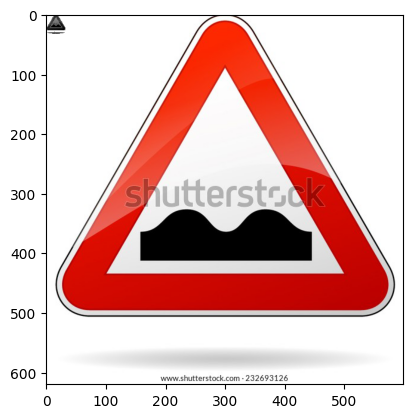

In [64]:
# predict internet number
import requests
from PIL import Image
url = 'https://www.shutterstock.com/image-vector/illustration-triangular-isolated-sign-bump-600w-232693126.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
 
# print("predicted sign: "+ str(model.predict(img)))
predict_x=model.predict(img)
plt.plot(predict_x)
# print("predicted sign: "+ str(predict_x))
predicted_class_index = np.argmax(predict_x)
print("Predicted class is:"+ str(predicted_class_index))
